In [1]:
import General.classes as classes
import General.functies as functies
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

In [ ]:
from pyparsing import oneOf


def get_data_from_folder(mypath):
    """
    @in: het adres van een folder waaruit data getrokken wordt
    @out:   een lijst met namen van de files
            een datalijst: datalijst[experiment] = np.array([ [tijden (sec)],  [spannning CH1 (V)], [spanning CH2 (V)] ])
    
    """
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] #met dank aan StackOverflow: een lijst met alle files in mypath
    datalijst = []

    for filenaam in onlyfiles:
        adres = mypath+'/'+filenaam
        file = open(adres, 'rt')
        data = file.read()
        file.close()
        data = data.replace(',','.') #ga naar deftige decimaalseparators
        inhoud = data.split('s	V	V')[1].split('\n')
        inhoudlijst = []
        #steek het in een lijst
        for regel in inhoud:
            if regel != '':
                lijst = regel.split('	')
                lijst = [float(elem) for elem in lijst]
                inhoudlijst.append(lijst.copy())
        inhoudlijst = np.array(inhoudlijst).T
        datalijst.append(inhoudlijst.copy())
    return onlyfiles, datalijst


def blokgolf(x, parameters): #een blokgolf met grootte G, frequentie f en offset x0, rond evenwichtspunt E
    f, G,  x0, E = parameters
    a = 2/f
    out = []
    for xval in x:
        xi = xval - x0
        periode = 1
        while not (periode-1)*a <= xi < periode*a:
            if xi < periode*a:
                periode -= 1
            else:
                periode += 1
        out.append(E + G*(-1)**periode)
    return np.array(out)

def sinus(x, parameters):
    A, k, phi, C = parameters
    return A*np.sin(k*x+phi)+C

def spanning_RLC(omega, parameters):
    V0, R, L, C = parameters
    spanning = V0*R/np.sqrt(R**2+(omega*L-1/(omega*C))**2)
    return spanning

def fase_RLC(omega, parameters):
    R, L, C = parameters
    fase = np.arctan((1-omega**2*L*C)/(omega*R*C)) #mijn uitwerking
    #fase = np.arctan(omega*R*C/(1-omega**2*L*C)) #Sam zijn uitwerking
    return fase

def fase_CR(omega, parameters):
    CR = parameters[0]
    fase = np.arctan(1/(omega*CR))
    return fase

def amplitude_CR(omega, parameters):
    CR, V0 = parameters
    amplitude = V0* omega*CR/np.sqrt(1+omega**2*CR**2)
    return amplitude
    
def constante(x, param):
    return param[0]

def output_RC_blokgolf(t, param):
    RC, V0, f, t0, E = param
    t -= t0 #shift nu al dan hoeven we er geen rekening meer mee te houden
    halveperiode = 2/(f)
    output = []
    for tijd in t: #bepaal in welke periode je zit. Niet te verwarren: halveperiode is de duur van 1 periode
        periode = 1
        while not (periode-1)*halveperiode <= tijd < periode*halveperiode:
            if tijd < periode*halveperiode:
                periode -= 1
            else:
                periode += 1
        tijdvak = periode
        tijdpriem = tijd - halveperiode*tijdvak

        if periode % 2 == 0: #in een even periode is het aan het opladen
            output.append(V0 * (1-np.exp((-tijdpriem)/RC)) + E)
        else: #in een oneven periode is het aan het ontladen
            output.append(V0 * (np.exp((-tijdpriem)/RC) * (np.exp(halveperiode/RC)-1)) + E)
    return np.array(output)

def RC_model(t, param, aditionals):
    TAU, A, C = param 
    V_0, up_down = aditionals #zet up_down = 0 voor up, 1 voor down
    #t_0 is initiële shift, b is breedte van blokgolf. aditionals worden meegegeven als argument en worden niet gefit
    offset = -TAU*np.log(abs(1-(V_0 + (-1)**up_down *C)/A))
    t = t-offset - t[0]
    return A*(-1)**(up_down)*(1-np.exp(-t/TAU)) + C


def fit_RC_oplading(xvals, yvals, y_err, initials, aditionals = None, limieten = None, plotting = False, detailed_logs = False, CH1 = None):
    def initial_vals_RC(xvals, yvals):
        return initials
    if aditionals is None:
        V_0 = yvals[0]
        if yvals[0] <= yvals[10]:
            up_down = 0
        else:
            up_down = 1
        aditionals = [V_0, up_down]
    display(aditionals)
    #display(limieten)
    outp = functies.fit(['TAU', 'A', 'C'], RC_model, initial_vals_RC, xvals, yvals, y_err, aditional_params=aditionals,
                         bounds=limieten, detailed_logs=detailed_logs)
    param_values = [out[0] for out in outp]
    if plotting:
        fig, ax = plt.subplots(1,1, figsize = (10,10))
        ax.errorbar(xvals, yvals, yerr=y_err, fmt = 'o', label = "Data CH2", markersize = 0.5)
        if CH1 is not None:
            ax.errorbar(xvals, CH1, color = 'k', label = "Blokgolf")
        t = np.linspace(min(xvals), max(xvals), 10000)
        ax.plot(t, RC_model(t, param_values, aditionals), label = "Model CH2")
        ax.set_xlabel("Tijd [s ofzo]")
        ax.set_ylabel("Spanning [V]")
        ax.legend()
        plt.show()
        
    return outp


    

def fit_blokgolf(xvals, yvals, invalslist, limieten = None, plotting = False):
    #extraheer één periode:
    indxmin = 1
    while abs(yvals[indxmin-1] - yvals[indxmin]) < 1: #deze loop zorgt dat indxmin het eerste punt van een fase (hoog of laag) is
        indxmin += 1
    indxmax = indxmin
    while abs(yvals[indxmax+1] - yvals[indxmax]) < 1: #deze loop zorgt dat indxmax het laatste punt van een fase (hoog of laag) is
        indxmax += 1
    def invals_const(x,y):
        return yvals[indxmin]
    const1 = fix_enkelzijdige_fout(functies.fit(["C1"], constante, invals_const, xvals[indxmin:indxmax+1], yvals[indxmin:indxmax+1], y_err = np.full(indxmax+1-indxmin, 0.1)))[0]
    #extraheer een tweede periode:
    indxmin2 = indxmax + 1
    while abs(yvals[indxmin2-1] - yvals[indxmin2]) < 1: #deze loop zorgt dat indxmin het eerste punt van een fase (hoog of laag) is
        indxmin2 += 1
    indxmax2 = indxmin2
    while abs(yvals[indxmax2+1] - yvals[indxmax2]) < 1: #deze loop zorgt dat indxmax het laatste punt van een fase (hoog of laag) is
        indxmax2 += 1
    def invals_const(x,y):
        return yvals[indxmin2]
    const2 = fix_enkelzijdige_fout(functies.fit(["C2"], constante, invals_const, xvals[indxmin2:indxmax2+1], yvals[indxmin2:indxmax2+1], y_err = np.full(indxmax2+1-indxmin2, 0.1)))[0]

    E = [(const1[0] + const2[0])/2, np.sqrt(const1[1]**2 + const2[1]**2)/2, 'S']
    G = [abs(const1[0] - const2[0])/2, np.sqrt(const1[1]**2 + const2[1]**2)/2, 'S']
    f = [4/(xvals[indxmax2+1]- xvals[indxmin]), (xvals[2] - xvals[1]), 'S'] #de fout = de resolutie #waarom de factor 4? idk man het werkt gewoon
    if yvals[indxmin2] > yvals[indxmin]: #als C2 de top is en C1 de bottom:
        x_0 = [xvals[indxmin-1], (xvals[2] - xvals[1]), 'S']
    else:
        x_0 = [xvals[indxmin2-1], (xvals[2] - xvals[1]), 'S']
    
    outp = [f, G, x_0, E] #hell yeah blokgolf fit omzeilen go brrr
    #outp = functies.fit(["f",'G',"x_0",'E'], blokgolf, invals, xvals, yvals, initial_range=limieten, y_err = np.full(np.shape(yvals), 5), detailed_logs = False, minimizemethod='fuck you')
    parameterwaarden = [param[0] for param in outp]
    if plotting:
        fig, ax = plt.subplots(1,1,)
        Xval = np.linspace(0,5,1000)
        ax.scatter(xvals, yvals, linestyle = '',label = 'data')
        ax.plot(Xval, blokgolf(Xval, parameterwaarden), label = 'model')
        #ax.plot(Xval, blokgolf(Xval, invalslist), label = 'invals')
        plt.tight_layout()
        ax.legend()
        plt.show()

    return outp

def fit_sinus(xvals, yvals, yerr, freqgok = 1, plotting = False, detailed_logs = False):
    #bepaal initiele waarden
    maximum = max(yvals)
    minimum = min(yvals)
    amplitude = (maximum - minimum)/2
    C = (maximum + minimum)/2
    if yvals[0] <= yvals[1]:
        if -1 <= (yvals[0] - C)/amplitude <= 1:
            phi = np.arcsin( (yvals[0] - C)/amplitude )
        else:
            phi = np.arcsin(yvals[0]/amplitude )
            C = 0
    else:
        if -1 <= (yvals[0] - C)/amplitude <= 1:
            phi = np.pi - np.arcsin( (yvals[0] - C)/amplitude )
        else:
            phi = np.pi - np.arcsin( yvals[0]/amplitude )
            C = 0

    def invals(x,y):
        return [amplitude, 2*np.pi*freqgok, phi, C]
    outp = functies.fit(['A','k','phi','C'], sinus, invals, xvals, yvals, y_err = yerr, detailed_logs=detailed_logs, fuck_CPU = True)
    plotparams = [elem[0] for elem in outp]
    if plotting:
        fig, ax = plt.subplots(1,1)
        ax.errorbar(xvals, yvals, yerr=yerr, linestyle = '', label = 'data')
        T = np.linspace(min(xvals),max(xvals),1000)
        ax.plot(T, sinus(T,plotparams),label = 'model')
        #ax.plot(T, sinus(T, invals(0,0)), label = 'invals')
        ax.legend()
        ax.set_xlabel('tijd (s)')
        ax.set_ylabel('spanning (mV of zo)')
        plt.tight_layout()
        plt.show()
    return outp

def fit_spanning_RLC(omegavals, yvals, omegaerr, yerr, title, invals = [1,1,1,1], bounds = None, ylim = None):
    def initvals(x,y): #fix deze initial values
        return invals
    outp = functies.fit_2D(['V0', 'R', 'L', 'C'], spanning_RLC, initvals, omegavals, yvals, omegaerr, yerr, bounds = bounds, titel = title, x_as_titel='$\\omega$ [Hz]', y_as_titel = 'spanning [V]', ylim = ylim, xlim = (0,35e3))
    return outp

def fit_fase_RLC(omegavals, fase, omegaerr, faseerr, title, invals = [1,1,1], bounds = None, ylim = None):
    def initvals(x,y):
        return invals
    outp = functies.fit_2D(['R', 'L', 'C'], fase_RLC, initvals, omegavals, fase, omegaerr, faseerr, bounds = bounds, titel = title, x_as_titel= '$\\omega$ [Hz]', y_as_titel = 'fase $\\phi$ [rad]', ylim = ylim, xlim = (0,35e3))
    return outp

def fix_enkelzijdige_fout(outp):
    """
    @in: de output van een functies.fit
    @out: hetzelfde maar de fouten zijn geen tuples meer
    """
    for indx in range(len(outp)):
        if type(outp[indx][1]) == tuple:
            outp[indx][1] = (abs(outp[indx][1][0])+abs(outp[indx][1][1]))/2
    return outp

def plot_fase_RLC_gelineariseerd(omega, phi, omega_err, phi_err, params, xlim = None, ylim = None):
    """
    @in: is wel duidelijk denk ik 
    """
    R = params[0][0]
    L = params[1][0]
    C = params[2][0]
    omega = np.array(omega)
    omega_err = np.array(omega_err)
    phi = np.array(phi)
    phi_err = np.array(phi_err)
    tanphi = np.tan(phi)
    tanphi_err = phi_err/(np.cos(phi)**2)
    rechterlid = (1-omega**2*L*C)/(omega*R*C)
    rechterlid_err = np.abs((1+omega**2*L*C)/(omega**2*R*C)*omega_err)

    omegalinspace = np.linspace(0,max(omega),1000)
    tanphilinspace = (1-omegalinspace**2*L*C)/(omegalinspace*R*C)
    fig, ax = plt.subplots(1,1,figsize = (10,10))
    ax.set_title('gelineariseerde plot van de fase')
    ax.set_ylabel('tan($\\phi$)')
    ax.set_xlabel('$\\frac{-1+\\omega^2RC}{\\omega R C}$')
    ax.errorbar(rechterlid, tanphi, xerr=rechterlid_err, yerr=tanphi_err, linestyle = '', label = 'data')
    ax.plot(tanphilinspace,tanphilinspace,label = 'model')
    ax.legend()
    if not xlim is None:
        ax.set_xlim(xlim)
    if not ylim is None:
        ax.set_ylim(ylim)
    plt.tight_layout()
    plt.show()

def fit_fase_CR(omegavals, fase, omegaerr, faseerr, invals):
    """
    @in: spreekt voor zich
    @out: het product C*R
    """
    def initvals(x,y):
        return invals
    outp = functies.fit_2D(['C * R'], fase_CR, initvals, omegavals, fase, omegaerr, faseerr, y_as_titel='Faseverschil [rad]',
                           x_as_titel='$\\omega$', titel = 'Faseplot bij de CR-kring', size = (30,10), xlim = (0,1500))
    return outp

def fit_amplitude_CR(omegavals, amplitude, omegaerr, amplitudeerr, invals):
    """
    @out: [[C*R en fout enzo], [V0 en fout enzo]]
    """
    def initvals(x,y):
        return invals
    outp = functies.fit_2D(['C*R','V0'], amplitude_CR, initvals, omegavals, amplitude, omegaerr, amplitudeerr,  y_as_titel='amplitude [V]',
                           x_as_titel='$\\omega$', titel = 'amplitudelot bij de CR-kring')
    return outp


[[-4.650199204424198, -4.668280295873653]]
C1 heeft als waarde: -4.6593 + -0.0090218 - -0.0090593 met 68% betrouwbaarheidsinterval: [-4.6502, -4.6683] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.018928
[[6.0752953128152685, 6.093682907444389]]
C2 heeft als waarde: 6.0845 + 0.0091699 - 0.0092176 met 68% betrouwbaarheidsinterval: [6.0753, 6.0937] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.027319


[-4.14407814408, 0]

[[0.10244744575729206, 0.1025982145254319], [19.228472992073403, 19.232536164898423], [-13.274314165883863, -13.27799032148505]]
TAU heeft als waarde: 0.10252 + 7.5589e-05 - 7.518e-05 met 68% betrouwbaarheidsinterval: [0.10245, 0.1026] 
A heeft als waarde: 19.231 + 0.0020277 - 0.0020355 met 68% betrouwbaarheidsinterval: [19.228, 19.233] 
C heeft als waarde: -13.276 + -0.0018412 - -0.001835 met 68% betrouwbaarheidsinterval: [-13.274, -13.278] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.34855
[[-4.650199204424198, -4.668280295873653]]
C1 heeft als waarde: -4.6593 + -0.0090218 - -0.0090593 met 68% betrouwbaarheidsinterval: [-4.6502, -4.6683] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.018928
[[6.0752953128152685, 6.093682907444389]]
C2 heeft als waarde: 6.0845 + 0.0091699 - 0.0092176 met 68% betrouwbaarheidsinterval: [6.0753, 6.0937] 
De p-waa

[5.68253968254, 1]

[[0.1014038395264579, 0.10155168167510659], [4.235522269923294, 9.251337519816303], [-0.30753151106102533, -0.3088024636791812]]
TAU heeft als waarde: 0.10148 + 7.405e-05 - 7.3792e-05 met 68% betrouwbaarheidsinterval: [0.1014, 0.10155] 
A heeft als waarde: 4.2361 + 5.0152 - 0.00057112 met 68% betrouwbaarheidsinterval: [4.2355, 9.2513] 
C heeft als waarde: -0.30817 + -0.00063381 - -0.00063714 met 68% betrouwbaarheidsinterval: [-0.30753, -0.3088] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.31478
[[6.153932149714302, 6.165925770143298]]
C1 heeft als waarde: 6.1599 + 0.0059903 - 0.0060033 met 68% betrouwbaarheidsinterval: [6.1539, 6.1659] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.021644
[[-4.707814831813351, -4.719514470946447]]
C2 heeft als waarde: -4.7137 + -0.0058218 - -0.0058779 met 68% betrouwbaarheidsinterval: [-4.7078, -4.7195] 
De p-w

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[-4.34432234432, 0]

[[0.10198527803189167, 0.1021311338995087], [19.867601000130882, 19.87000457745004], [-13.828021728010583, -13.83033619458513]]
TAU heeft als waarde: 0.10206 + 7.3048e-05 - 7.2808e-05 met 68% betrouwbaarheidsinterval: [0.10199, 0.10213] 
A heeft als waarde: 19.869 + 0.0011991 - 0.0012045 met 68% betrouwbaarheidsinterval: [19.868, 19.87] 
C heeft als waarde: -13.829 + -0.0011601 - -0.0011544 met 68% betrouwbaarheidsinterval: [-13.828, -13.83] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0.99928
De gereduceerde chi^2 waarde is: 0.74902
[[6.153932149714302, 6.165925770143298]]
C1 heeft als waarde: 6.1599 + 0.0059903 - 0.0060033 met 68% betrouwbaarheidsinterval: [6.1539, 6.1659] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.021644
[[-4.707814831813351, -4.719514470946447]]
C2 heeft als waarde: -4.7137 + -0.0058218 - -0.0058779 met 68% betrouwbaarheidsinterval: [-4.7078, -4.7195] 
De 

[5.70695970696, 1]

[[0.10205208978517283, 0.10219873507055555], [4.277901440777096, 8.505566068420116], [-0.3436533314552722, -0.3448131238631849]]
TAU heeft als waarde: 0.10213 + 7.3485e-05 - 7.3161e-05 met 68% betrouwbaarheidsinterval: [0.10205, 0.1022] 
A heeft als waarde: 4.2784 + 4.2271 - 0.00053157 met 68% betrouwbaarheidsinterval: [4.2779, 8.5056] 
C heeft als waarde: -0.34423 + -0.00057818 - -0.00058162 met 68% betrouwbaarheidsinterval: [-0.34365, -0.34481] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0.99997
De gereduceerde chi^2 waarde is: 0.70127


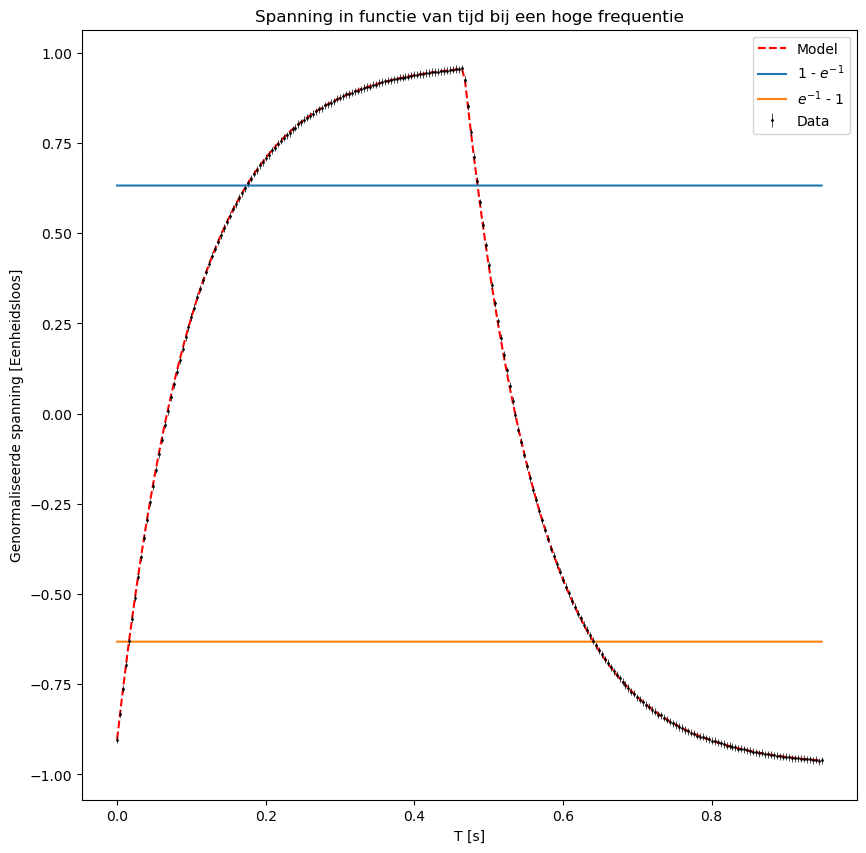

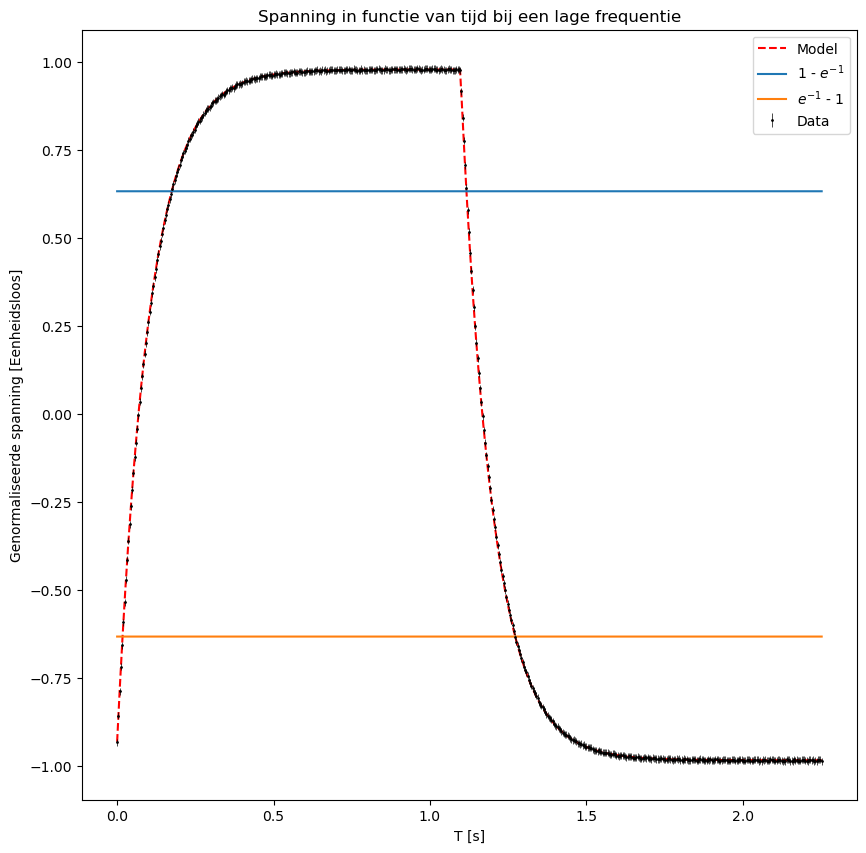

In [14]:
#kapot
mypath = "RLC proef/RC"
namen, datalijst = get_data_from_folder(mypath)
freqgoks = [4.2,2]  
verschuivingen = [0, 0]
limietlijst = [[(1,6), (5,7), (0,2),(-1,1)], None]
RC_lims = [[(0.002,1), (0,100), (-4,4)], [(0,1), (0,100), (-4,4)]]

slices_high_freq = [(122, 239), (239, 360)] #eerste is positief deel van blokgolf
slices_low_freq = [(198, 473), (473, 762)] #eerste is positief deel van blokgolf
slices = [slices_high_freq, slices_low_freq]

RC_params = []
blokgolf_params = []
times = []
datas = []
for i in range(2):
    for j in range(2):
        tijd = datalijst[i][0]
        CH1 = datalijst[i][1]
        CH2 = datalijst[i][2]

        fase_1 = tijd[slices[i][j][0]: slices[i][j][1]]
        CH1_fase_1 = CH1[slices[i][j][0]: slices[i][j][1]]
        CH2_fase_1 = CH2[slices[i][j][0]: slices[i][j][1]]
        times.append(fase_1)
        datas.append(CH2_fase_1)

        top = max(CH1)
        bot = min(CH1)
        invalslist = [freqgoks[0], (top-bot)/2, verschuivingen[0], (top+bot)/2]

        outp = fit_blokgolf(tijd, CH1, invalslist, limieten = limietlijst[1], plotting=False)
        f, G, x_0, E = outp
        parameterwaarden_CH1 = [f[0], G[0], x_0[0], E[0]]
        blokgolf_params.append(parameterwaarden_CH1)

        RC_vals = fit_RC_oplading(fase_1, CH2_fase_1, y_err=np.full(np.shape(CH2_fase_1),0.01), initials=[0.1, G[0], -E[0]],plotting=False, detailed_logs=False, CH1 = CH1_fase_1)
        RC_params.append([RC_val[0] for RC_val in RC_vals])

titels = ["Spanning in functie van tijd bij een hoge frequentie", "Spanning in functie van tijd bij een lage frequentie"]
for i in range(2):
    tijd_opl = times[2*i]
    tijd_afl = times[1 + 2*i]

    tijd_opl_space = np.linspace(tijd_opl[0], tijd_opl[-1], 10000)
    tijd_afl_space = np.linspace(tijd_afl[0], tijd_afl[-1], 10000)

    RC_data_opl = datas[2*i]
    RC_data_afl = datas[1 + 2*i]

    RC_model_opl = RC_model(tijd_opl_space, RC_params[2*i], [RC_data_opl[0], 0])
    RC_model_afl = RC_model(tijd_afl_space, RC_params[2*i + 1], [RC_data_afl[0], 1])

    data_opl_norm = (RC_data_opl - blokgolf_params[2*i][3])/blokgolf_params[2*i][1]
    data_afl_norm = (RC_data_afl - blokgolf_params[2*i +1][3])/blokgolf_params[2*i +1][1]

    opl_norm = (RC_model_opl - blokgolf_params[2*i][3])/blokgolf_params[2*i][1]
    afl_norm = (RC_model_afl - blokgolf_params[2*i+1][3])/blokgolf_params[2*i + 1][1]
    
    totaal_spanning = np.concatenate((np.array(opl_norm), np.array(afl_norm)))
    totaal_tijd = np.concatenate((np.array(tijd_opl), np.array(tijd_afl)))
    totaal_space = np.concatenate((np.array(tijd_opl_space), np.array(tijd_afl_space)))
    totaal_data = np.concatenate((np.array(data_opl_norm), np.array(data_afl_norm)))

    fig, ax = plt.subplots(1,1, figsize = (10,10))
    ax.plot(totaal_space - totaal_space[0], totaal_spanning, color = "r", label = "Model", linestyle = "--")
    ax.errorbar(totaal_tijd - totaal_tijd[0], totaal_data, yerr=np.full(np.shape(totaal_data), 0.01), color = "k", fmt = "o", label = "Data", markersize = 1, elinewidth=0.5)
    ax.plot(totaal_space- totaal_space[0], np.full(np.shape(totaal_space), 1-np.exp(-1)), label = "1 - $e^{-1}$")
    ax.plot(totaal_space- totaal_space[0], np.full(np.shape(totaal_space), np.exp(-1)-1), label = "$e^{-1}$ - 1")
    ax.set_xlabel("T [s]")
    ax.set_ylabel("Genormaliseerde spanning [Eenheidsloos]")
    ax.set_title(titels[i])
    ax.legend()
    plt.show()
    




input bij freq 0.12
[[5.811479433981451, 5.8126715299814515], [0.6002944972985715, 0.6005925212985714], [3.050788023681027, 3.0510860476810273], [0.5079242682835243, 0.5088183402835242]]
A heeft als waarde: 5.8121 + 0.00059605 - 0.00059605 met 68% betrouwbaarheidsinterval: [5.8115, 5.8127] 
k heeft als waarde: 0.60044 + 0.00014901 - 0.00014901 met 68% betrouwbaarheidsinterval: [0.60029, 0.60059] 
phi heeft als waarde: 3.0509 + 0.00014901 - 0.00014901 met 68% betrouwbaarheidsinterval: [3.0508, 3.0511] 
C heeft als waarde: 0.50837 + 0.00044704 - 0.00044704 met 68% betrouwbaarheidsinterval: [0.50792, 0.50882] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 450.09
output bij freq 0.12
[[0.3496842133102386, 0.3508763093102386], [0.6015133288758391, 0.601811352875839], [-1.7382704628745136, -1.7352902228745137], [-0.010138661746402024, -0.009244589746402024]]
A heeft als waarde: 0.35028 + 0.00059605 - 0.00059605 met 68% betr

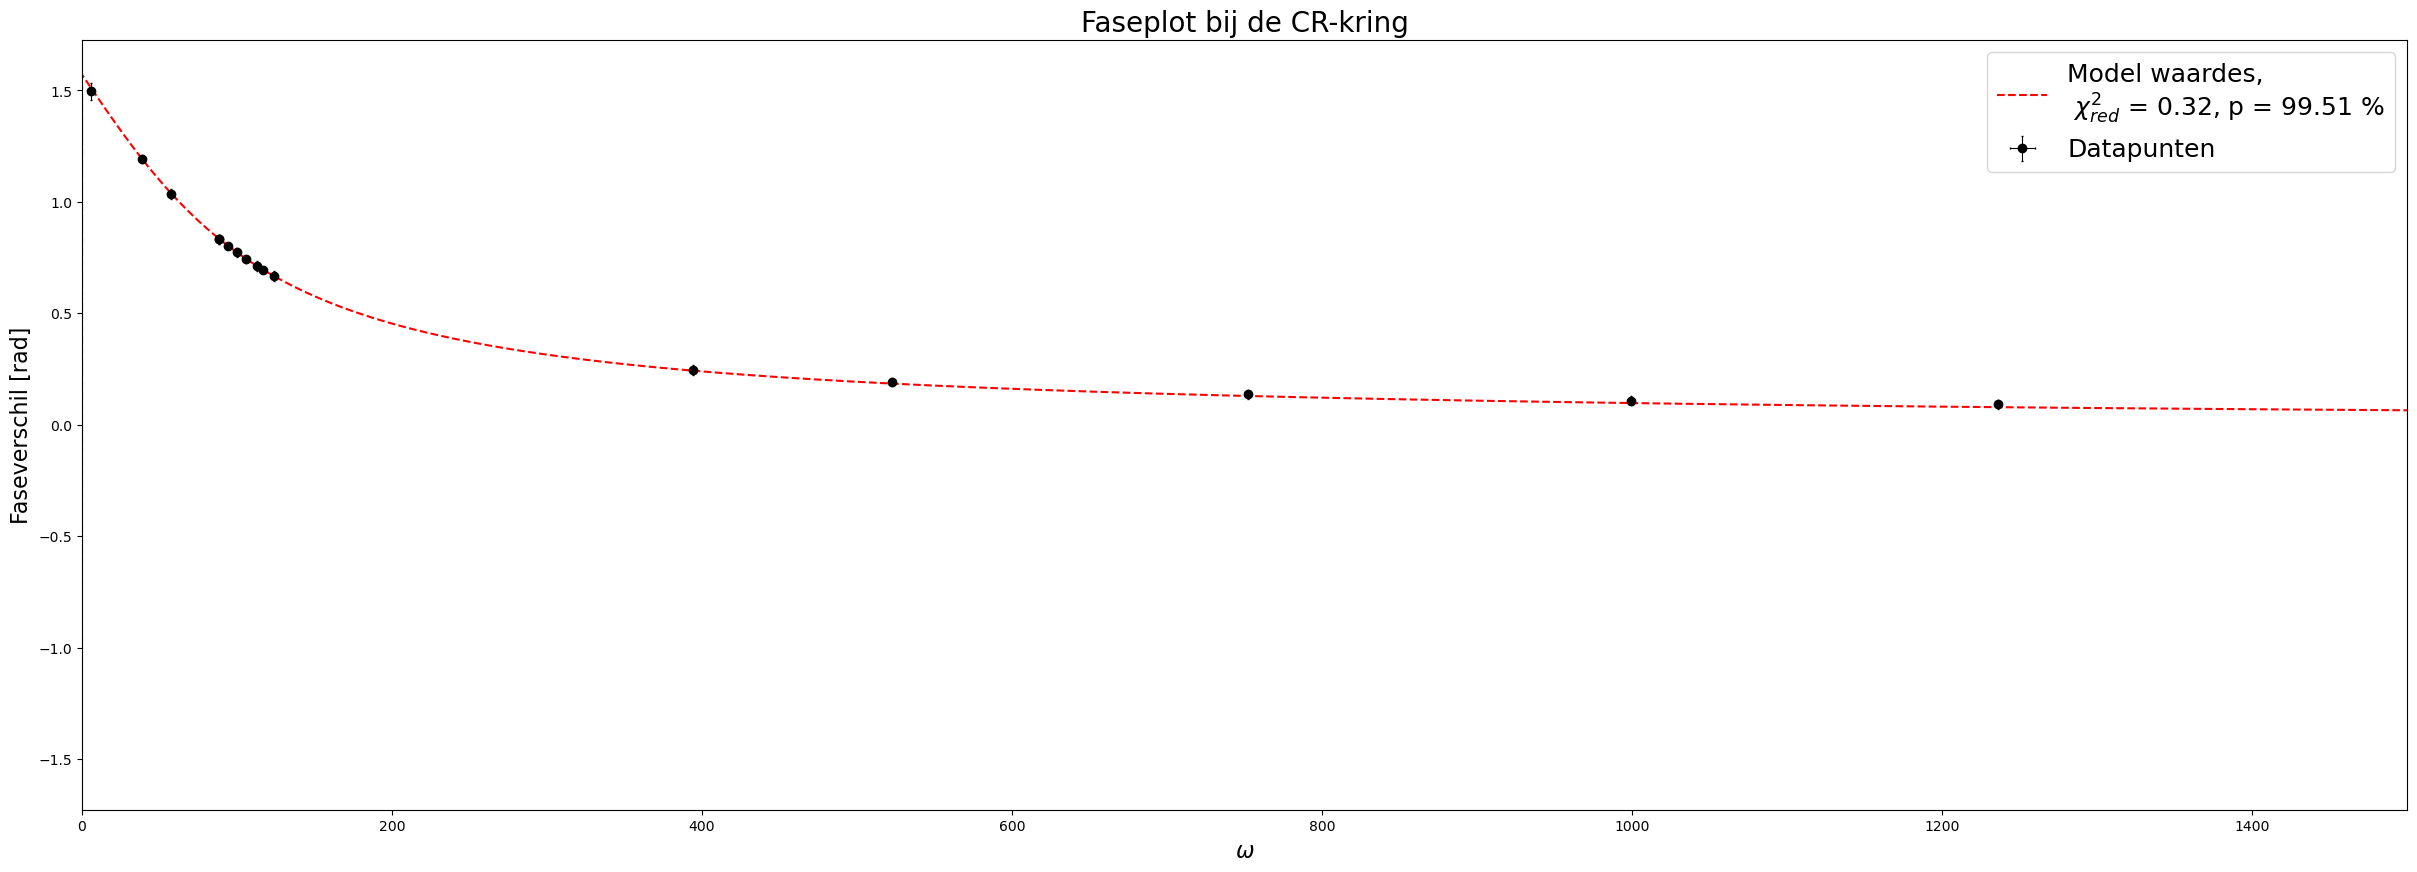

[0.05, 6]
[5.00000000e-02 6.00000000e+00 5.92613990e+00 3.86954973e+01
 5.74859943e+01 8.86347460e+01 8.86347513e+01 9.42998825e+01
 9.99492641e+01 1.06072251e+02 1.12757003e+02 1.17028502e+02
 7.52275710e+02 9.99156444e+02 1.23696454e+02 1.23636678e+03
 3.94228245e+02 3.86340462e+03 5.22326065e+02]
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334BF89F80>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334D356AC0>
[[0.010238841721562293, 0.010372625144446384], [5.747646014402133, 5.7743115695020695]]
C*R heeft als waarde: 0.010305 + 6.7205e-05 - 6.6578e-05 met 68% betrouwbaarheidsinterval: [0.010239, 0.010373] 
V0 heeft als waarde: 5.761 + 0.013333 - 0.013333 met 68% betrouwbaarheidsinterval: [5.7476, 5.7743] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.017211


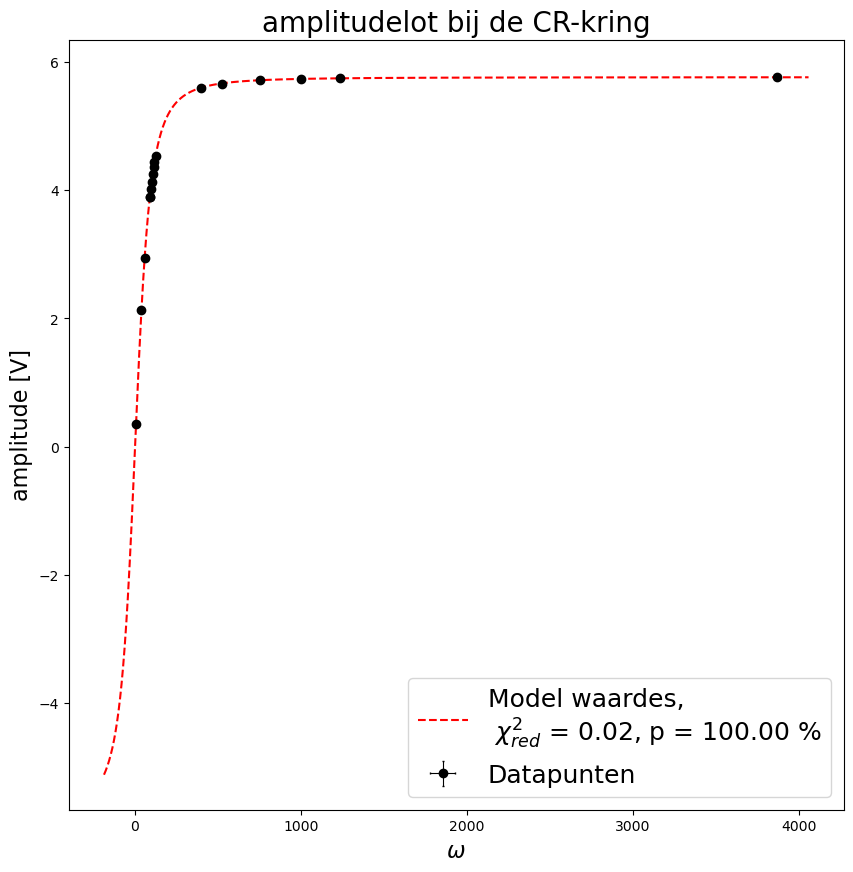

[[0.010247782154082398, 0.0001194164448277378, 'S']]

C:\Users\samfa\AppData\Local\Temp\ipykernel_28992\1256267074.py:65: RuntimeWarning: divide by zero encountered in divide
  fase = np.arctan(1/(omega*CR))


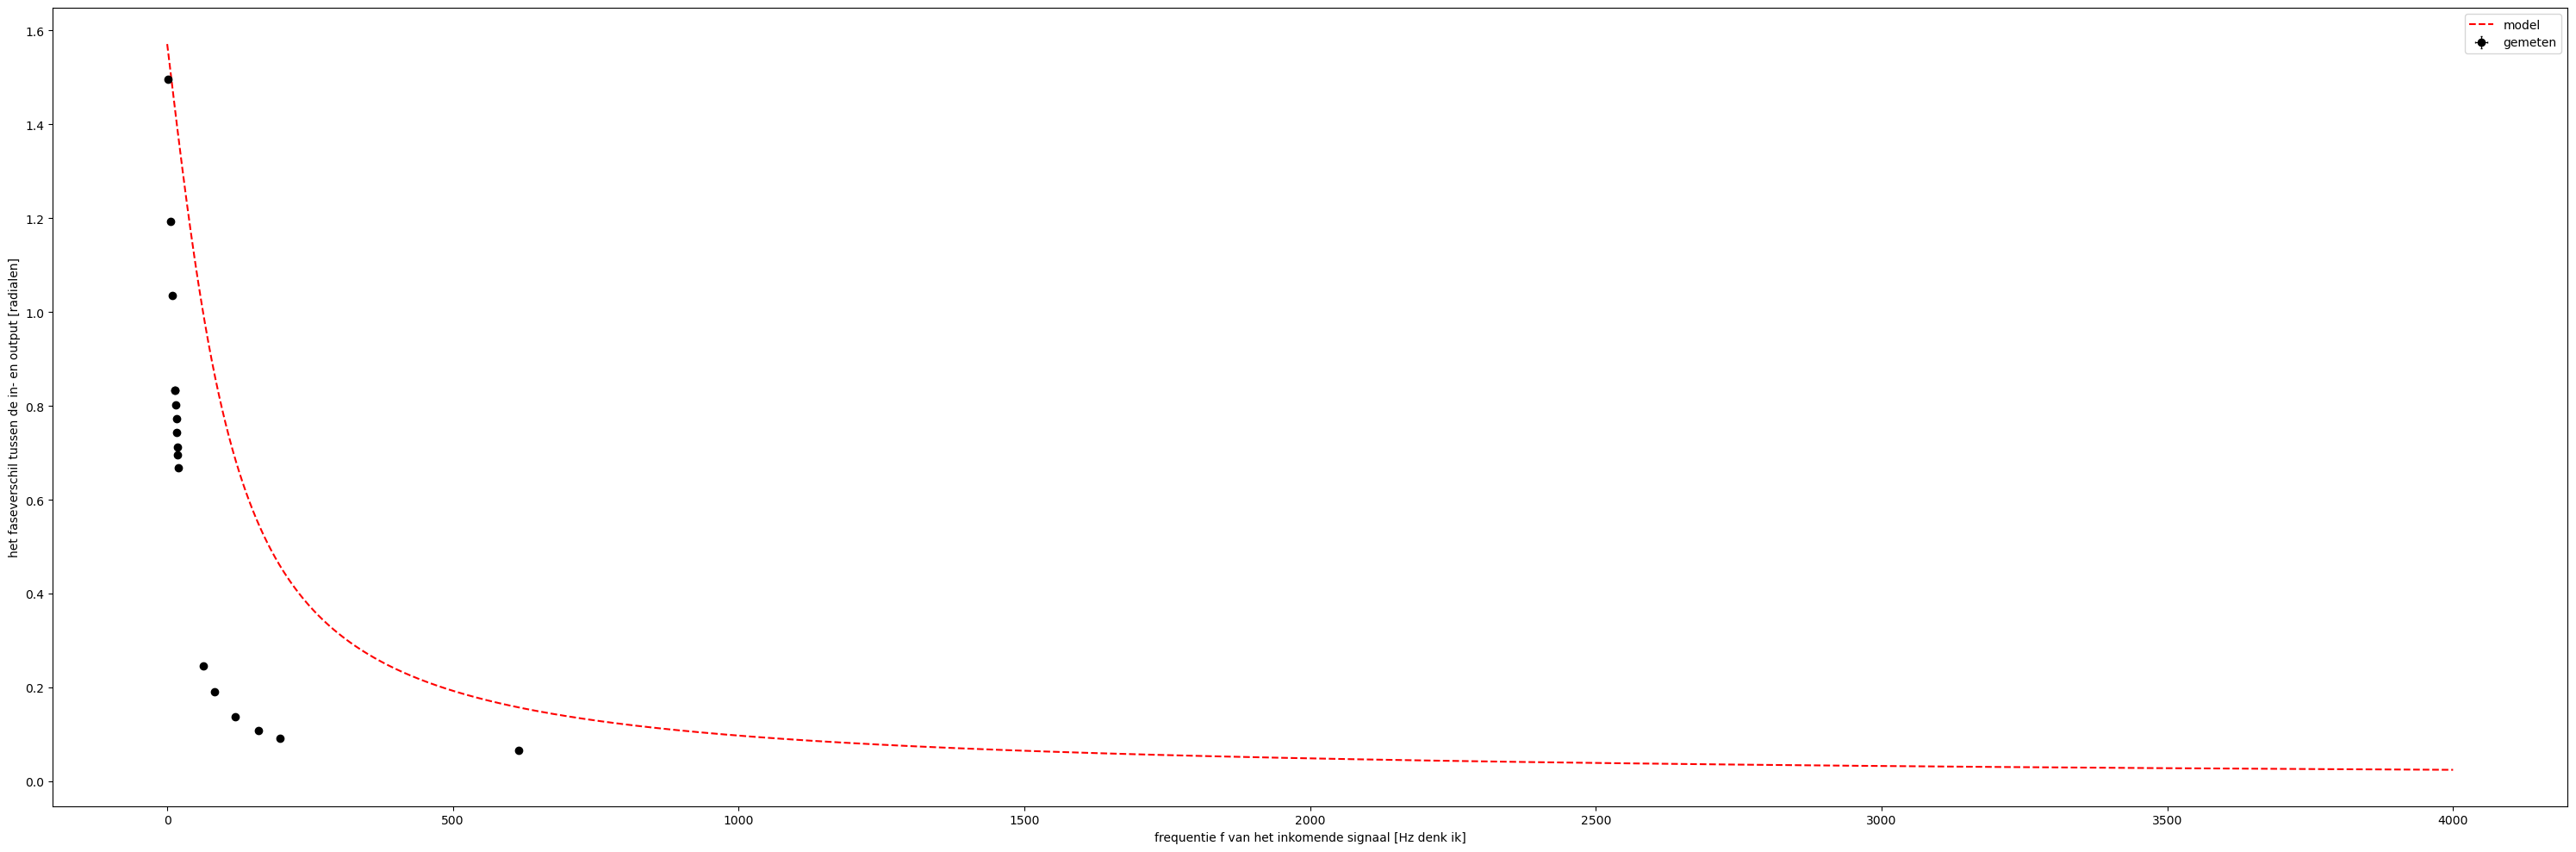

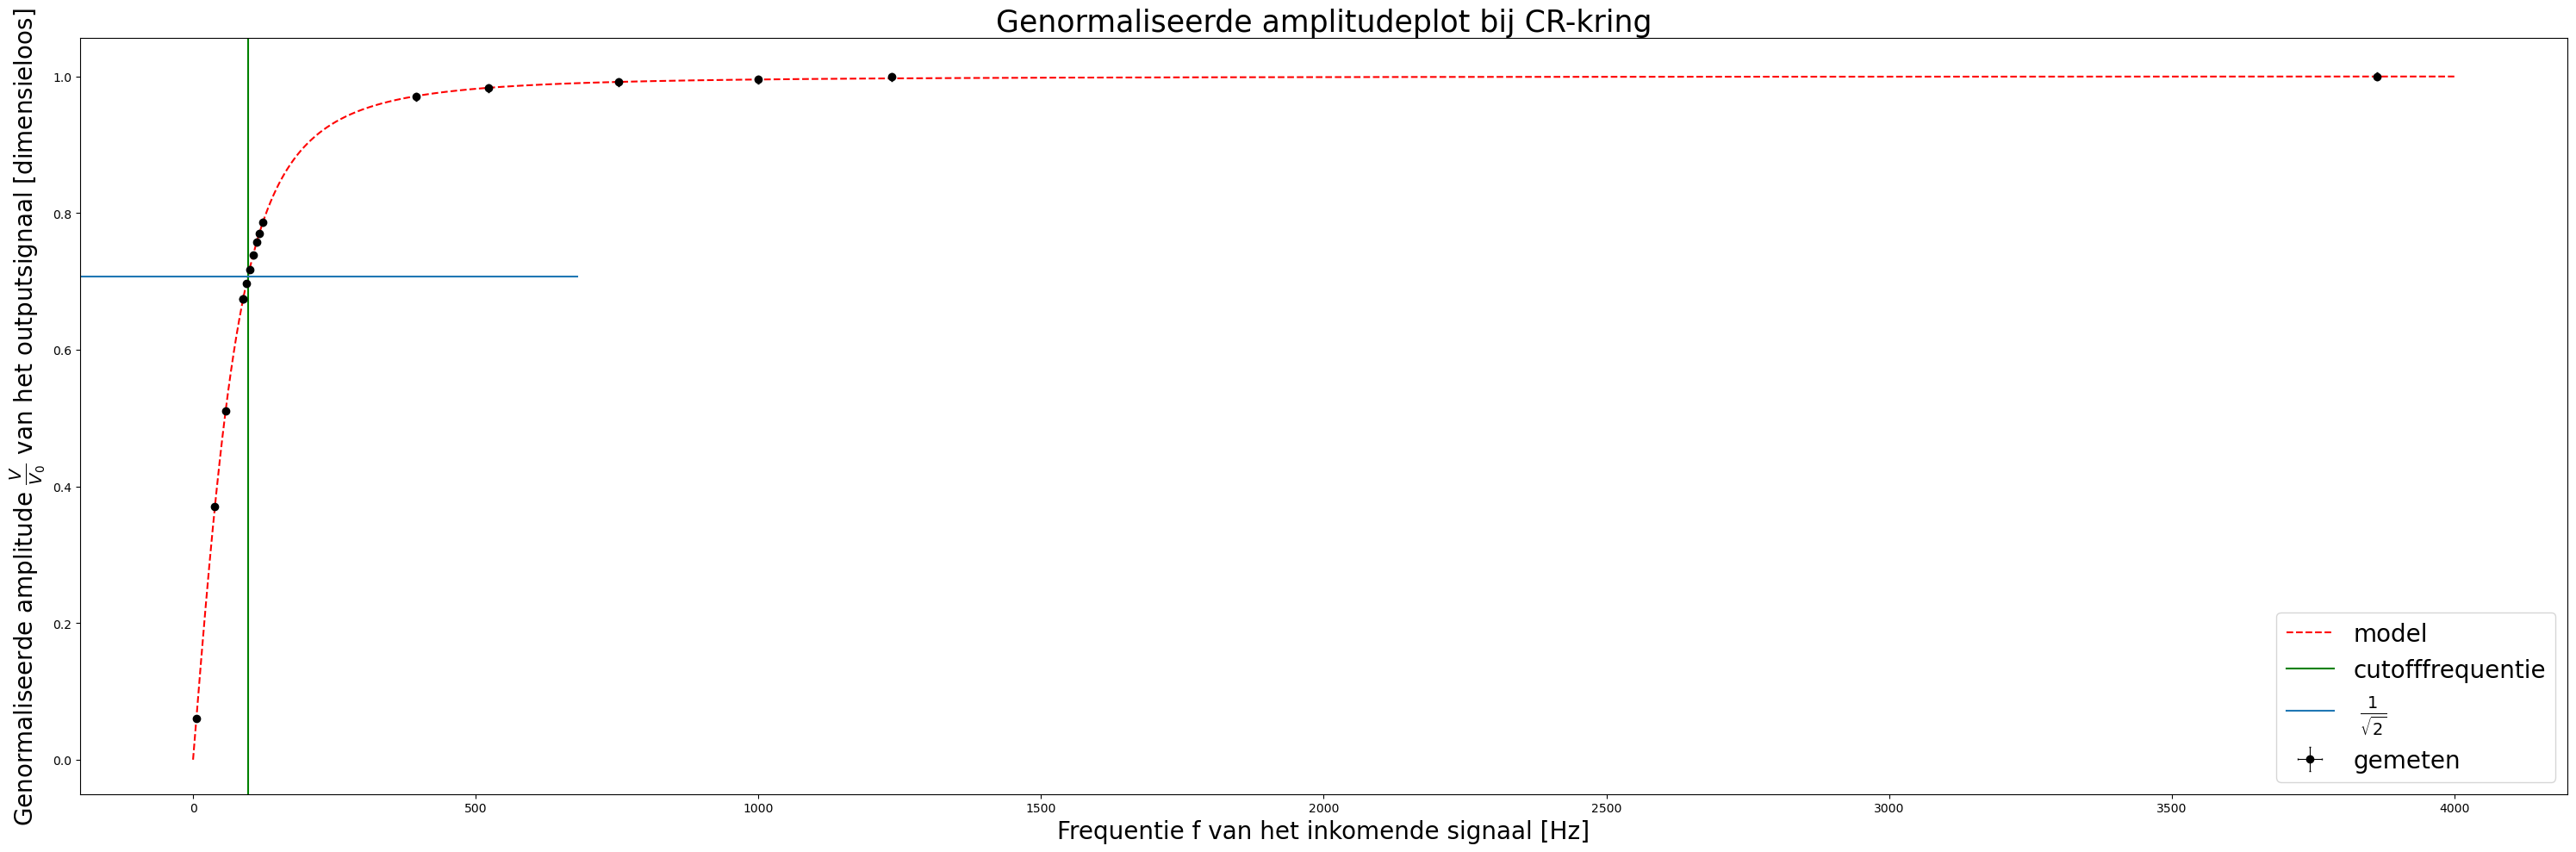

In [17]:
mypath = "RLC proef/CR"
namen, datalijst = get_data_from_folder(mypath)

fase = [] #het faseverschil tussen het in-en outputsignaal
fasefout = []

input_f = [] #frequentie (!= hoekfrequentie) van het inputsignaal
input_f_fout = []

amplitude = [] #de amplitude van het outputsignaal
amplitudefout = []
for indx in range(len(datalijst)):
    freqgok = float(namen[indx].replace('CRkring - freq','').replace('.txt',''))
    dataset = datalijst[indx]
    tijden, CH1, CH2 = dataset
    print('input bij freq', freqgok)
    inputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH1, np.full(np.shape(CH1), 0.01),freqgok = freqgok, plotting = False, detailed_logs=False))
    print('output bij freq', freqgok)
    outputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH2, np.full(np.shape(CH2), 0.01), freqgok = freqgok, plotting = False, detailed_logs=False))
    hoek = outputsinus[2][0] - inputsinus[2][0]
    hoekfout = np.sqrt(outputsinus[2][1]**2+inputsinus[2][1]**2)
    while -np.pi > hoek:
        hoek += 2*np.pi
    while hoek > np.pi:
        hoek -= 2*np.pi
    fase.append(hoek)
    fasefout.append(hoekfout)
    input_f.append(inputsinus[1][0]/2*np.pi)
    input_f_fout.append(inputsinus[1][1]/2*np.pi)
    amplitude.append(outputsinus[0][0])
    amplitudefout.append(outputsinus[0][1])
input_f = np.array(input_f)
input_f_fout = np.array(input_f_fout)
amplitudefout = np.array(amplitudefout)
amplitude = np.array(amplitude)
fase_val_CR = fit_fase_CR(input_f*2*np.pi,fase, input_f_fout*2*np.pi, fasefout, [10e3 * 5e-6])
CR, V0 = fit_amplitude_CR(input_f*2*np.pi, amplitude, input_f_fout*2*np.pi, amplitudefout, [10e3 * 5e-6, 6])

#de faseplot
fig, ax = plt.subplots(1,1, figsize = (30,10))
ax.errorbar(input_f, fase, xerr = input_f_fout, yerr = fasefout, label = 'gemeten', linestyle = '', marker = 'o', color = "k", elinewidth=0.8, capsize=1)
omegarange = np.linspace(0,4000, 4000)
display(fase_val_CR)
ax.plot(omegarange, fase_CR(omegarange, [fase_val_CR[0][0]]), label = 'model', linestyle = '--', color = 'r')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('het faseverschil tussen de in- en output [radialen]')
ax.legend()
plt.tight_layout()
plt.show()
#de genormaliseerde amplitudeplot
cutofffrequentie = 1/CR[0]
fig, ax = plt.subplots(1,1, figsize = (30,10))
yerr = np.sqrt((amplitudefout/V0[0])**2+(amplitude/(V0[0]**2)*V0[1]**2)) #de totale fout op de genormaliseerde amplitude
ax.errorbar(input_f*2*np.pi, amplitude/V0[0], xerr = input_f_fout*2*np.pi, yerr = yerr, label = 'gemeten', linestyle = '', fmt = 'o', color = "k", ecolor= "k", elinewidth=0.8, capsize=1)
omegarange = np.linspace(0,4000, 4000)
ax.plot(omegarange, amplitude_CR(omegarange, [CR[0], 1]), label = 'model', linestyle = '--', color = 'r')
ax.set_xlabel("Frequentie f van het inkomende signaal [Hz]", fontsize = 20)
ax.set_ylabel('Genormaliseerde amplitude $\\frac{V}{V_0}$ van het outputsignaal [dimensieloos]', fontsize = 20)
ax.set_title('Genormaliseerde amplitudeplot bij CR-kring', fontsize = 25)
plt.axvline(cutofffrequentie, label = 'cutofffrequentie', color = 'green')
plt.axhline(np.sqrt(2)/2, 0, 0.2, label = ' $\\frac{1}{\\sqrt{2}}$')
ax.legend(fontsize = 20)
plt.tight_layout()
plt.show()

input bij freq 100.0
[[5.758335480061428, 5.762507816061428], [642.9599238627086, 642.9833187467086], [2.2927261669826273, 2.2936202389826277], [0.5027689034593472, 0.5057491434593473]]
A heeft als waarde: 5.7604 + 0.0020862 - 0.0020862 met 68% betrouwbaarheidsinterval: [5.7583, 5.7625] 
k heeft als waarde: 642.97 + 0.011623 - 0.011772 met 68% betrouwbaarheidsinterval: [642.96, 642.98] 
phi heeft als waarde: 2.2932 + 0.00044704 - 0.00044704 met 68% betrouwbaarheidsinterval: [2.2927, 2.2936] 
C heeft als waarde: 0.50426 + 0.0014901 - 0.0014901 met 68% betrouwbaarheidsinterval: [0.50277, 0.50575] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 4.2343e-177
De gereduceerde chi^2 waarde is: 6.048
output bij freq 100.0
[[5.737215660679216, 5.741387996679216], [642.9580863724805, 642.9814812564805], [2.3762289206496066, 2.377122992649607], [-0.015104833980783444, -0.012124593980783445]]
A heeft als waarde: 5.7393 + 0.0020862 - 0.0020862 met 68% betrouwbaarheid

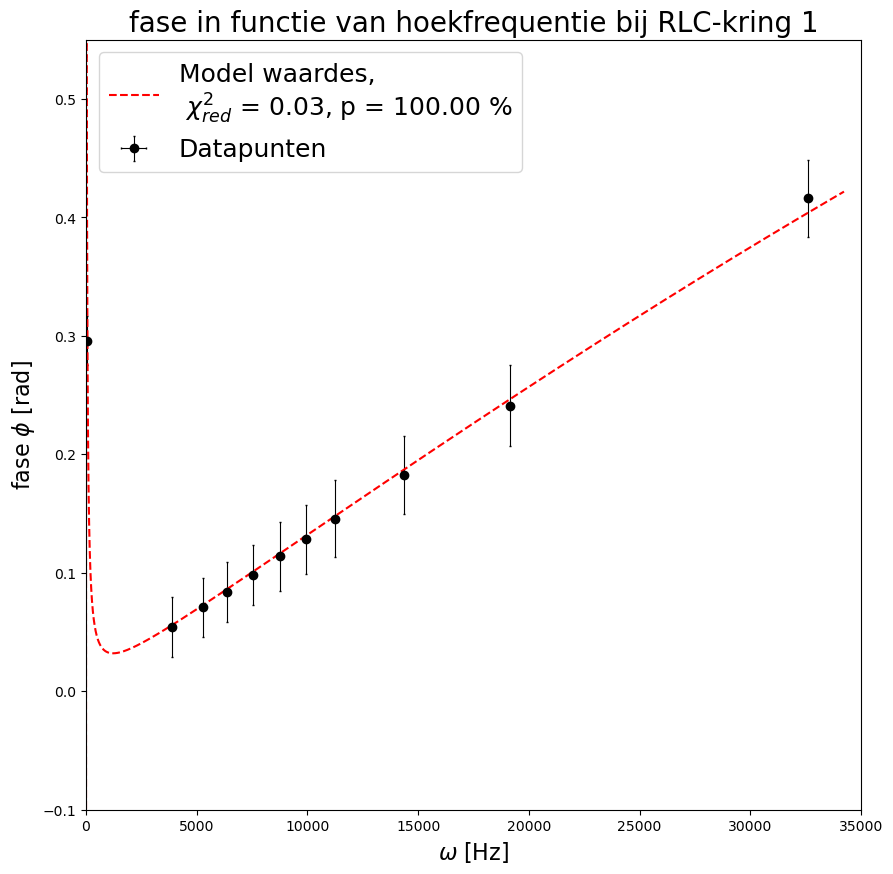

[5.766281674666878, 10000.0, 0.0088, 5e-05]
[5.76628167e+00 1.00000000e+04 8.80000000e-03 5.00000000e-05
 6.34587628e+03 7.53491663e+03 8.75753415e+03 9.93507508e+03
 1.12409239e+04 6.44479973e+01 1.43815804e+04 1.91659658e+04
 3.26031647e+04 3.86649691e+03 5.30005686e+03]
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B2CFD80>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B298720>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B298720>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B298720>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B29A160>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B29A160>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B29A160>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B29A160>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B29A160>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B29A160>
<funct

C:\Users\samfa\AppData\Local\Temp\ipykernel_28992\1127328029.py:54: RuntimeWarning: divide by zero encountered in divide
  spanning = V0*R/np.sqrt(R**2+(omega*L-1/(omega*C))**2)


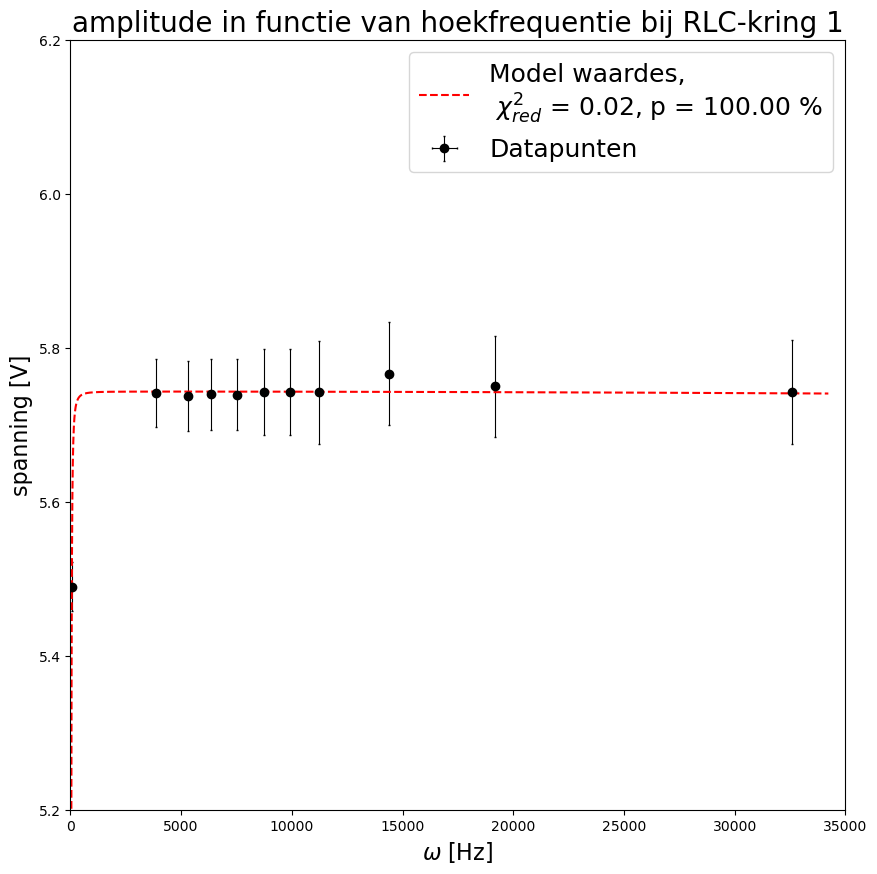

[[5.743044316277566, 0.032708742053307205, 'S'], [9999.999998963434, (1210.736850792775, 1817.4875746108191), 'S'], [0.008839025302124097, 5.008839025302124, 'S'], [5.046395057468653e-06, (6.11028283466046e-07, 9.166931470803011e-07), 'S']]


'\n#de faseplot\nfig, ax = plt.subplots(1,1)\nax.errorbar(input_f, fase, xerr = input_f_fout, yerr = fasefout, label = \'gemeten\', linestyle = \'\', marker = \'o\')\nax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")\nax.set_ylabel(\'het faseverschil tussen de in- en output [radialen]\')\nax.legend()\nplt.tight_layout()\nplt.show()\n#de amplitudeplot\nfig, ax = plt.subplots(1,1)\nax.errorbar(input_f, amplitude, xerr = input_f_fout, yerr = amplitudefout, label = \'gemeten\', linestyle = \'\', marker = \'o\')\nax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")\nax.set_ylabel(\'de amplitude van het outputsignaal [V]\')\nax.legend()\nplt.tight_layout()\nplt.show()'

In [5]:
mypath = "RLC proef/RLC1"
namen, datalijst = get_data_from_folder(mypath)

fase = [] #het faseverschil tussen het in-en outputsignaal
fasefout = []

input_f = [] #frequentie (!= hoekfrequentie) van het inputsignaal
input_f_fout = []

amplitude = [] #de amplitude van het outputsignaal
amplitudefout = []
for indx in range(len(datalijst)):
    freqgok = float(namen[indx].replace('RLCkring - ','').replace('Hz.txt',''))
    dataset = datalijst[indx]
    tijden, CH1, CH2 = dataset
    print('input bij freq', freqgok)
    inputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH1, np.full(np.shape(CH1), 0.01),freqgok = freqgok, plotting = False, detailed_logs=False))
    print('output bij freq', freqgok)
    outputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH2, np.full(np.shape(CH2), 0.01), freqgok = freqgok, plotting = False, detailed_logs=False))
    #dus basically: de code fit insane goed, maar het duurt wel een volle minuut
    hoek = outputsinus[2][0] - inputsinus[2][0]
    hoekfout = np.sqrt(outputsinus[2][1]**2+inputsinus[2][1]**2)
    while -np.pi > hoek:
        hoek += 2*np.pi
    while hoek > np.pi:
        hoek -= 2*np.pi
    fase.append(hoek)
    fasefout.append(hoekfout)
    input_f.append(inputsinus[1][0]/2*np.pi)
    input_f_fout.append(inputsinus[1][1]/2*np.pi)
    amplitude.append(outputsinus[0][0])
    amplitudefout.append(outputsinus[0][1])
input_f = np.array(input_f)
input_f_fout = np.array(input_f_fout)
print('GEFIT:')
outp_fase = fit_fase_RLC(input_f*2*np.pi, fase, input_f_fout*2*np.pi, fasefout,'fase in functie van hoekfrequentie bij RLC-kring 1', invals = [10e3, 4*2.2e-3, 5*10e-6], ylim = (-0.1,0.55))#, bounds = [(1e3,1e5), (1e-3,2e-2),(0,1e-4)])
#plot_fase_RLC_gelineariseerd(input_f*2*np.pi, fase, input_f_fout*2*np.pi, fasefout, [[10e3], [4*2.2e-3], [5*10e-6]])
print(fit_spanning_RLC(input_f*2*np.pi, amplitude, input_f_fout*2*np.pi, amplitudefout,'amplitude in functie van hoekfrequentie bij RLC-kring 1',
                       invals = [max(amplitude), 10e3, 4*2.2e-3, 5*10e-6], bounds = [(0,10), (1e3,1e5), (1e-3,2e-2),(0,1e-4)],
                       ylim = (5.2,6.2)))
"""
#de faseplot
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, fase, xerr = input_f_fout, yerr = fasefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('het faseverschil tussen de in- en output [radialen]')
ax.legend()
plt.tight_layout()
plt.show()
#de amplitudeplot
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, amplitude, xerr = input_f_fout, yerr = amplitudefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('de amplitude van het outputsignaal [V]')
ax.legend()
plt.tight_layout()
plt.show()"""

input bij freq 100.0
[[4.204915482486316, 4.212664106486316], [652.9700252772636, 653.0343984612637], [-1.5094323814762713, -1.5073462134762714], [0.5079282588569072, 0.5135907148569072]]
A heeft als waarde: 4.2088 + 0.0038743 - 0.0038743 met 68% betrouwbaarheidsinterval: [4.2049, 4.2127] 
k heeft als waarde: 653 + 0.032187 - 0.032187 met 68% betrouwbaarheidsinterval: [652.97, 653.03] 
phi heeft als waarde: -1.5084 + 0.0010431 - 0.0010431 met 68% betrouwbaarheidsinterval: [-1.5094, -1.5073] 
C heeft als waarde: 0.51076 + 0.0028312 - 0.0028312 met 68% betrouwbaarheidsinterval: [0.50793, 0.51359] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.63372
output bij freq 100.0
[[3.116634000258132, 3.1246806482581317], [652.9534140476713, 653.0390959476713], [-1.2470674787313656, -1.2443852627313654], [-0.019430851292152378, -0.013768395292152376]]
A heeft als waarde: 3.1207 + 0.0040233 - 0.0040233 met 68% betrouwbaarheidsint

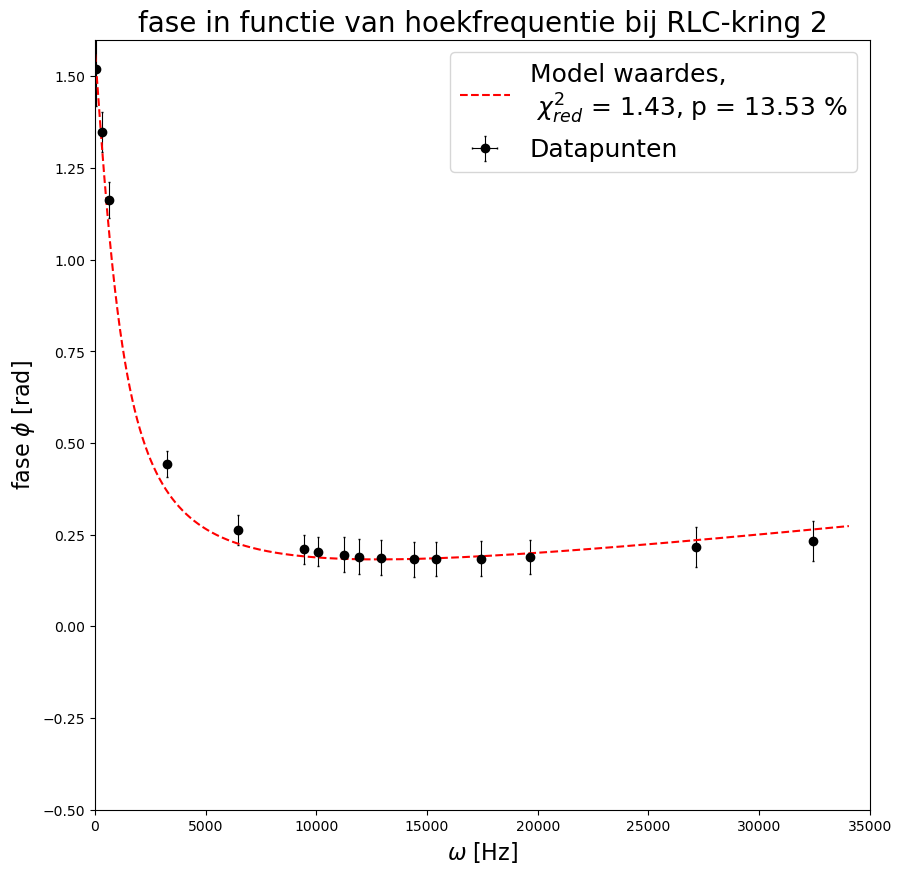

[3.147347036733829, 100, 0.0088, 5e-05]
[3.14734704e+00 1.00000000e+02 8.80000000e-03 5.00000000e-05
 6.44487350e+03 6.42003289e+02 9.44763081e+03 1.00619179e+04
 1.12433787e+04 1.19181283e+04 6.34781782e+01 1.28982852e+04
 1.44156118e+04 1.54032311e+04 1.74404092e+04 1.96617270e+04
 2.71368445e+04 3.24321987e+04 3.26952914e+03 3.35170267e+02]
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334BFC37E0>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B38C2C0>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B38C680>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B38C680>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B38C680>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B38C680>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B38C680>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B38C680>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002334B38C680>
<funct

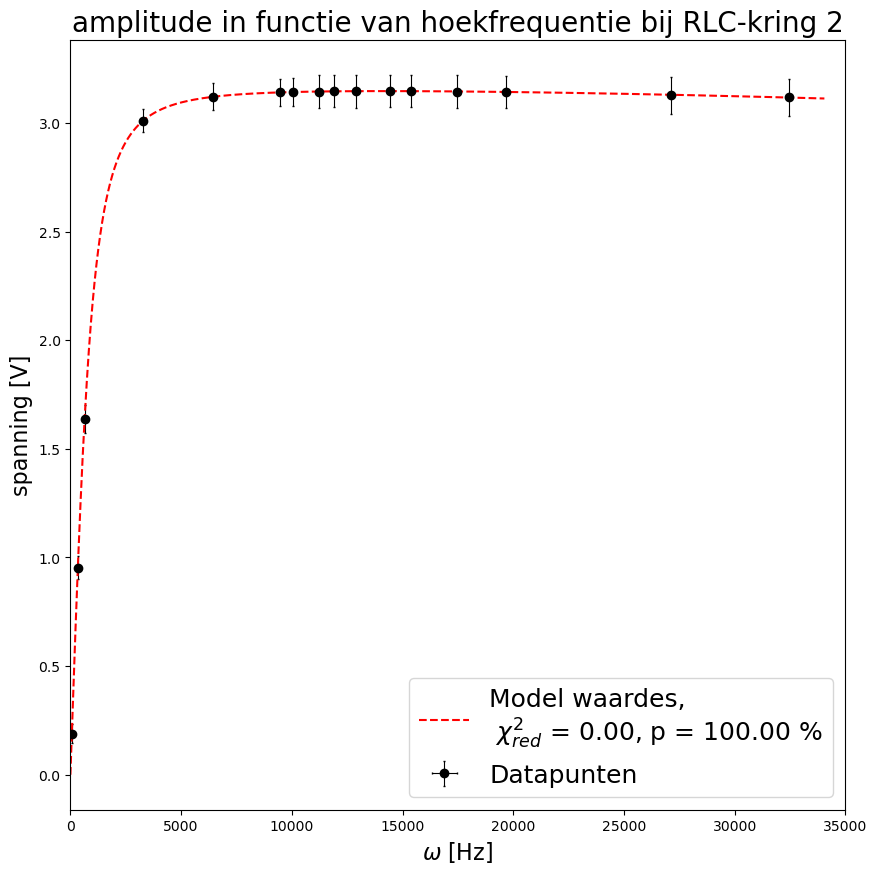

[[3.18174264303905, 0.04208471745674158, 'S'], [103.68325465268812, 8.811555308503841, 'S'], [-0.0005520517851756439, 5.000552051785176, 'S'], [9.031011816992364e-06, 7.75736321621529e-07, 'S']]


'\nfig, ax = plt.subplots(1,1)\nax.errorbar(input_f, fase, xerr = input_f_fout, yerr = fasefout, label = \'gemeten\', linestyle = \'\', marker = \'o\')\nax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")\nax.set_ylabel(\'het faseverschil tussen de in- en output [radialen]\')\nax.legend()\nplt.tight_layout()\nplt.show()\n#de amplitudeplot\nfig, ax = plt.subplots(1,1)\nax.errorbar(input_f, amplitude, xerr = input_f_fout, yerr = amplitudefout, label = \'gemeten\', linestyle = \'\', marker = \'o\')\nax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")\nax.set_ylabel(\'de amplitude van het outputsignaal [V]\')\nax.legend()\nplt.tight_layout()\nplt.show()'

In [6]:
mypath = "RLC proef/RLC2"
namen, datalijst = get_data_from_folder(mypath)

fase = [] #het faseverschil tussen het in-en outputsignaal
fasefout = []

input_f = [] #frequentie (!= hoekfrequentie) van het inputsignaal
input_f_fout = []

amplitude = [] #de amplitude van het outputsignaal
amplitudefout = []
for indx in range(len(datalijst)):
    freqgok = float(namen[indx].replace('RLC2 - ','').replace('Hz.txt',''))
    dataset = datalijst[indx]
    tijden, CH1, CH2 = dataset
    print('input bij freq', freqgok)
    inputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH1, np.full(np.shape(CH1), 0.02),freqgok = freqgok, plotting = False, detailed_logs=False))
    print('output bij freq', freqgok)
    outputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH2, np.full(np.shape(CH2), 0.02), freqgok = freqgok, plotting = False, detailed_logs=False))
    #de fits zijn insane ze duren wederom een volle minuut tho
    hoek = outputsinus[2][0] - inputsinus[2][0]
    hoekfout = np.sqrt(outputsinus[2][1]**2+inputsinus[2][1]**2)
    while -np.pi > hoek:
        hoek += 2*np.pi
    while hoek > np.pi:
        hoek -= 2*np.pi
    fase.append(hoek)
    fasefout.append(hoekfout)
    input_f.append(inputsinus[1][0]/2*np.pi)
    input_f_fout.append(inputsinus[1][1]/2*np.pi)
    amplitude.append(outputsinus[0][0])
    amplitudefout.append(outputsinus[0][1])
input_f = np.array(input_f)
input_f_fout = np.array(input_f_fout)
#de faseplot
print('GEFIT:')
outp = fit_fase_RLC(input_f*2*np.pi, fase, input_f_fout*2*np.pi, fasefout,'fase in functie van hoekfrequentie bij RLC-kring 2', invals = [100, 4*2.2e-3, 5*10e-6], bounds = [(10,1000),(-2e-2,2e-2),(10e-6,1e-4)],
                    ylim = (-0.5,1.6))
#plot_fase_RLC_gelineariseerd(input_f*2*np.pi, fase, input_f_fout*2*np.pi, fasefout, outp, xlim = (0,20))
print(fit_spanning_RLC(input_f*2*np.pi, amplitude, input_f_fout*2*np.pi, amplitudefout,'amplitude in functie van hoekfrequentie bij RLC-kring 2', invals = [max(amplitude), 100, 4*2.2e-3, 5*10e-6]))
"""
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, fase, xerr = input_f_fout, yerr = fasefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('het faseverschil tussen de in- en output [radialen]')
ax.legend()
plt.tight_layout()
plt.show()
#de amplitudeplot
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, amplitude, xerr = input_f_fout, yerr = amplitudefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('de amplitude van het outputsignaal [V]')
ax.legend()
plt.tight_layout()
plt.show()"""